<a href="https://colab.research.google.com/github/abdullahalmusabbir/Review-Paper-Code/blob/main/4_Detection_of_breast_cancer_using_machine_learning_and_explainable_artificial_intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap, lime.lime_tabular, eli5
from anchor import anchor_tabular
# import feyn # Removed due to inability to install qlattice dependency
# from feyn import QLattice # Removed due to inability to install qlattice dependency

In [72]:
df = pd.read_csv("breast-cancer-dataset.csv")
print("Initial Shape:", df.shape)

Initial Shape: (213, 11)


In [73]:
# Drop useless columns (if exist)
for col in ["id", "Unnamed: 32"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Encode categorical (if string labels)
for c in df.select_dtypes(include="object").columns:
    df[c] = LabelEncoder().fit_transform(df[c])

# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing
df.fillna(df.median(numeric_only=True), inplace=True)

print("After cleaning shape:", df.shape)

After cleaning shape: (213, 11)


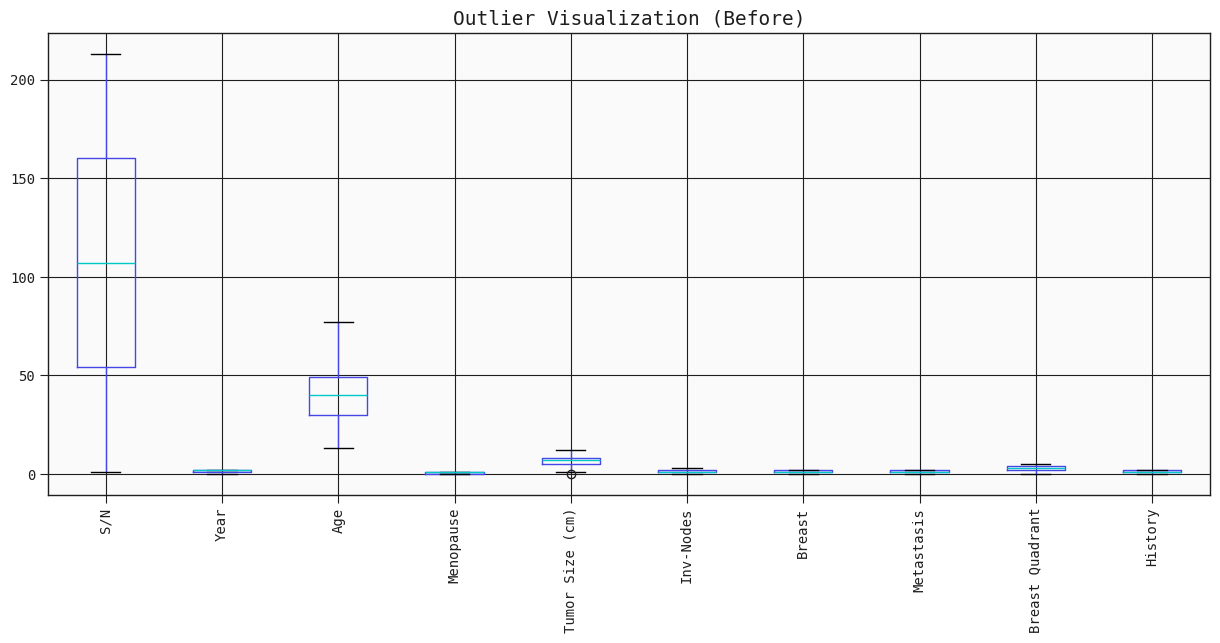

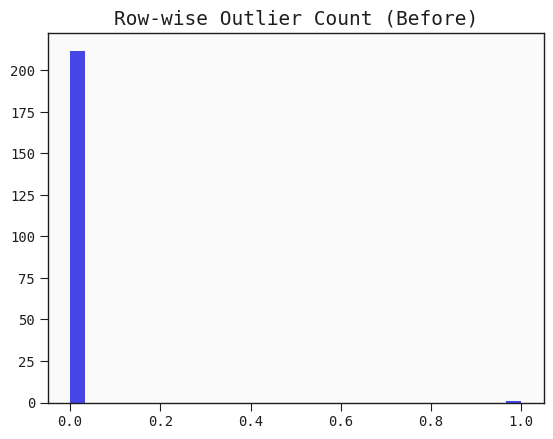

In [74]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = "diagnosis" if "diagnosis" in df.columns else num_cols[-1]
features = [c for c in num_cols if c != target_col]

plt.figure(figsize=(15,6))
df[features].boxplot()
plt.title("Outlier Visualization (Before)")
plt.xticks(rotation=90)
plt.show()

def outlier_count_per_row(dataframe, cols):
    Q1 = dataframe[cols].quantile(0.25)
    Q3 = dataframe[cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask_lower = dataframe[cols].lt(lower, axis=1)
    mask_upper = dataframe[cols].gt(upper, axis=1)
    outlier_count = (mask_lower | mask_upper).sum(axis=1)
    return outlier_count

plt.hist(outlier_count_per_row(df, features), bins=30)
plt.title("Row-wise Outlier Count (Before)")
plt.show()

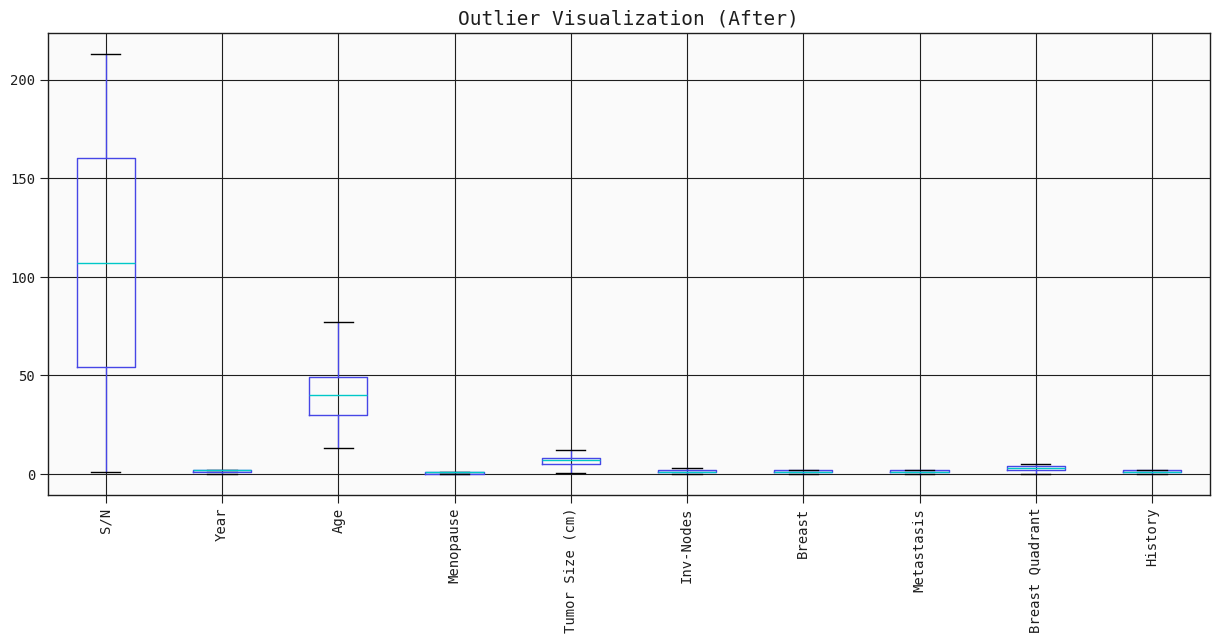

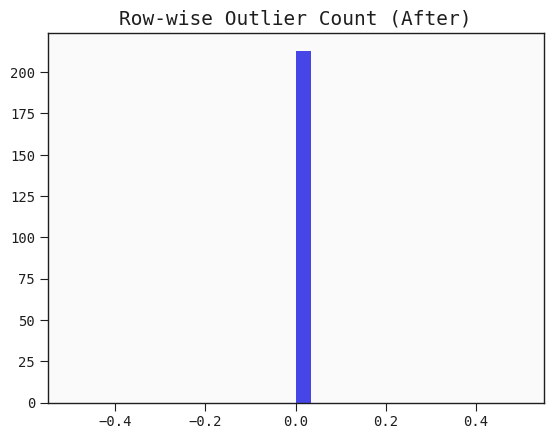

In [75]:
def iqr_winsorize(dataframe, cols):
    capped = dataframe.copy()
    for c in cols:
        Q1 = capped[c].quantile(0.25)
        Q3 = capped[c].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        capped[c] = capped[c].clip(lower, upper)
    return capped

df[features] = iqr_winsorize(df, features)[features]

# Visualization (After)
plt.figure(figsize=(15,6))
df[features].boxplot()
plt.title("Outlier Visualization (After)")
plt.xticks(rotation=90)
plt.show()

plt.hist(outlier_count_per_row(df, features), bins=30)
plt.title("Row-wise Outlier Count (After)")
plt.show()

In [76]:
X = df[features]
y = df[target_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [77]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}



RandomForest Accuracy: 0.9070
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.89      0.89      0.89        19

    accuracy                           0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43



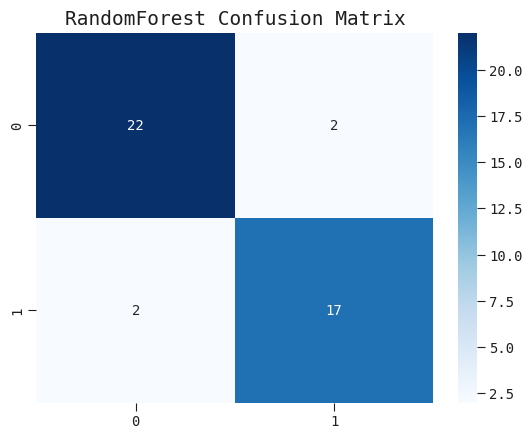


LogisticRegression Accuracy: 0.9535
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      0.89      0.94        19

    accuracy                           0.95        43
   macro avg       0.96      0.95      0.95        43
weighted avg       0.96      0.95      0.95        43



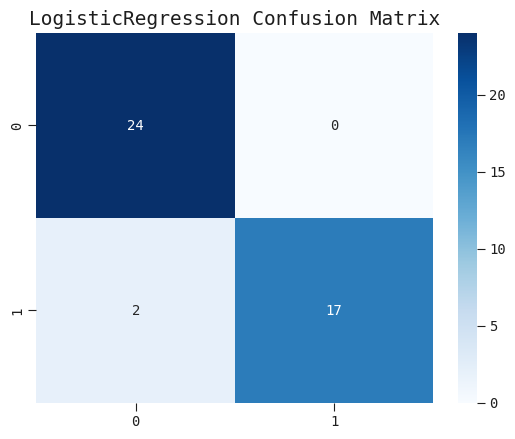


CatBoost Accuracy: 0.9302
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.94      0.89      0.92        19

    accuracy                           0.93        43
   macro avg       0.93      0.93      0.93        43
weighted avg       0.93      0.93      0.93        43



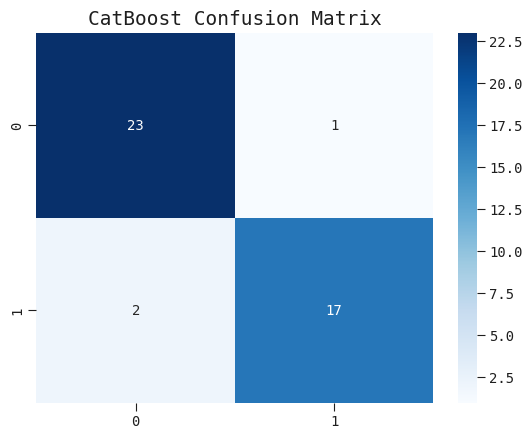


XGBoost Accuracy: 0.8837
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.89      0.84      0.86        19

    accuracy                           0.88        43
   macro avg       0.88      0.88      0.88        43
weighted avg       0.88      0.88      0.88        43



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:50:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


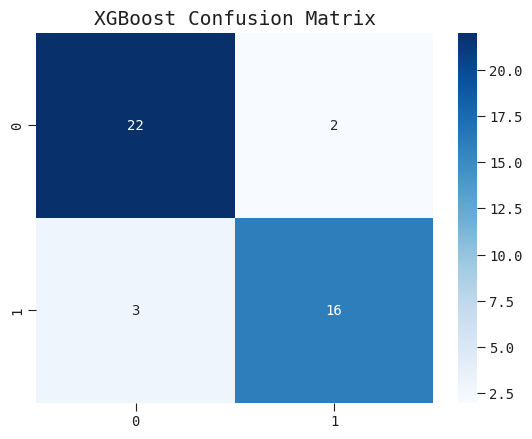

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 74, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435294 -> initscore=-0.260283
[LightGBM] [Info] Start training from score -0.260283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

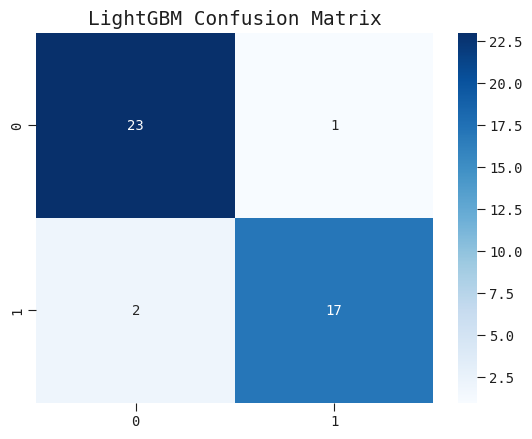


AdaBoost Accuracy: 0.8837
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.94      0.79      0.86        19

    accuracy                           0.88        43
   macro avg       0.89      0.87      0.88        43
weighted avg       0.89      0.88      0.88        43



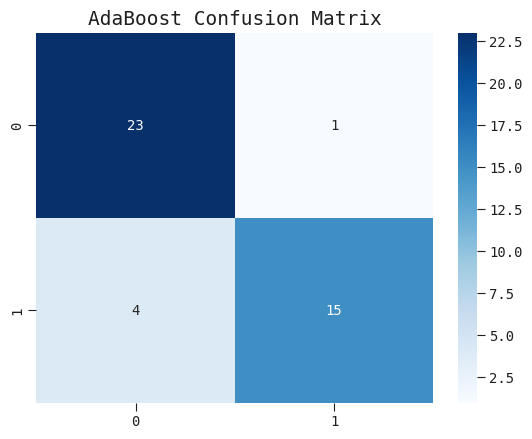


KNN Accuracy: 0.8837
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       1.00      0.74      0.85        19

    accuracy                           0.88        43
   macro avg       0.91      0.87      0.88        43
weighted avg       0.90      0.88      0.88        43



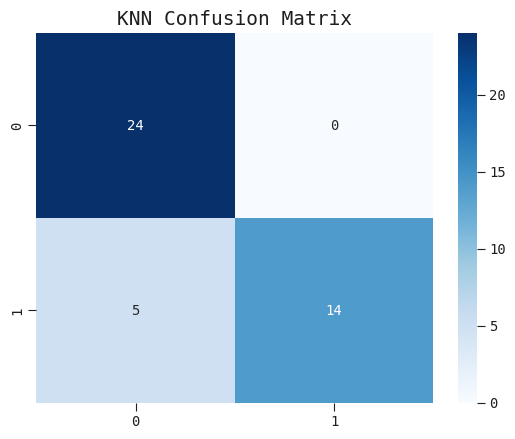


DecisionTree Accuracy: 0.8372
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.80      0.84      0.82        19

    accuracy                           0.84        43
   macro avg       0.83      0.84      0.84        43
weighted avg       0.84      0.84      0.84        43



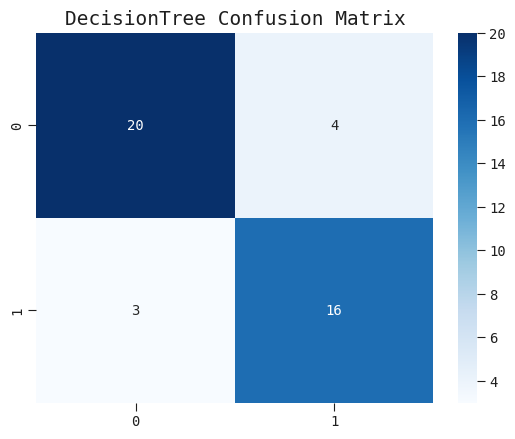

In [78]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    results[name] = acc

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()


Best model: LogisticRegression


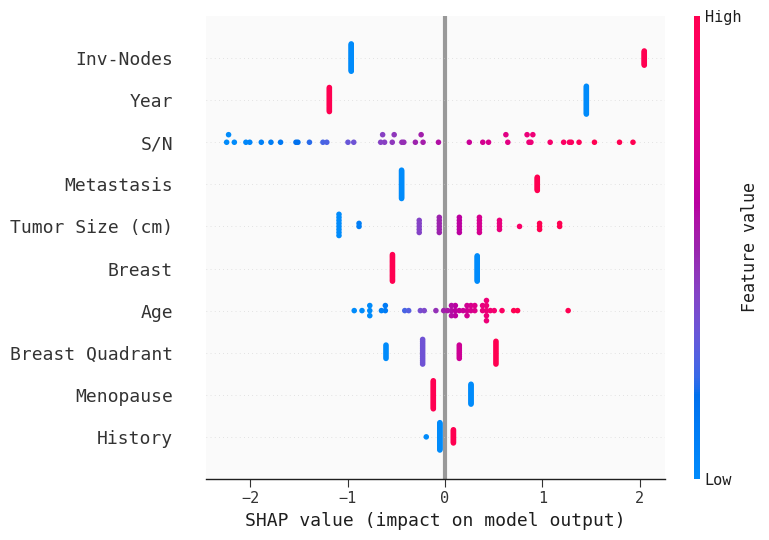

Anchor Explanation: ['Inv-Nodes > -0.69', 'Metastasis > -0.70']


In [79]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print("\nBest model:", best_model_name)

# SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:50])
shap.summary_plot(shap_values, X_test[:50], feature_names=features)

# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=features, class_names=["Class0","Class1"], discretize_continuous=True
)
i = 0
exp = lime_explainer.explain_instance(X_test[i], best_model.predict_proba)
exp.show_in_notebook(show_table=True)

# ELI5
eli5.show_weights(best_model, feature_names=features)

# Anchor
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=["Class0","Class1"],
    feature_names=features,
    train_data=X_train
)
exp_anchor = anchor_explainer.explain_instance(X_test[0], best_model.predict, threshold=0.95)
print("Anchor Explanation:", exp_anchor.names())


In [80]:
train_df.isnull().sum()

,0
S/N,0
Year,0
Age,0
Menopause,0
Tumor Size (cm),0
Inv-Nodes,0
Breast,0
Metastasis,0
Breast Quadrant,0
History,0


In [81]:
train_df = train_df.dropna()


In [82]:
train_df = train_df.fillna(train_df.mean())

In [83]:
train_df["target"].unique()

array([0., 1.])